In [8]:
import pandas as pd
import torch

# Load the contents of function_smell_embeddings.pt
old_embed = torch.load('./old_embeddings.pt')
fix_embed = torch.load('./fixed_codes_embeddings.pt')
smell_key = pd.read_csv("combined_codes_updated.csv")["SmellKey"]
smell_key

0      0
1      0
2      0
3      0
4      0
      ..
595    1
596    1
597    1
598    1
599    1
Name: SmellKey, Length: 600, dtype: int64

# Import

In [43]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

In [40]:
# Combine the embeddings and encoded messages into a DataFrame
data = pd.DataFrame({
    'old_code': old_embed.tolist(),
    'fixed_code': fix_embed.tolist(),
    'smellKey_encoded': smell_key
})

# Split the data into features (embeddings) and labels (messages)
#numpy.darray
X = np.array(data['old_code'].tolist())
#X = np.column_stack((data['old_code'].tolist(), data['fixed_code'].tolist()))

print(X.shape)
y = np.array(data['smellKey_encoded'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).unsqueeze(1)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test).unsqueeze(1)
y_test_tensor = torch.tensor(y_test)


(600, 768)


# Model

In [41]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

# Define the model parameters
input_dim = X_train_tensor.shape[2]
hidden_dim = 128
output_dim = len(np.unique(y_train))

print(input_dim, hidden_dim, output_dim)

# Create the LSTM model
model = LSTMModel(input_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader objects
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Define empty lists to store evaluation metrics
train_accuracy_list = []
val_accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

768 128 2


# Train

In [42]:
# Training the LSTM model
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        #print(outputs.shape)
        #print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    # Evaluate the LSTM model
    with torch.no_grad():
        model.eval()
        train_outputs = model(X_train_tensor.float())
        _, train_predicted = torch.max(train_outputs.data, 1)
        train_accuracy = (train_predicted == y_train_tensor).sum().item() / len(y_train_tensor)

        val_outputs = model(X_test_tensor.float())
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_accuracy = (val_predicted == y_test_tensor).sum().item() / len(y_test_tensor)

        train_precision = precision_score(y_train_tensor, train_predicted, average='weighted', zero_division=1)
        val_precision = precision_score(y_test_tensor, val_predicted, average='weighted', zero_division=1)

        train_recall = recall_score(y_train_tensor, train_predicted, average='weighted')
        val_recall = recall_score(y_test_tensor, val_predicted, average='weighted')

        train_f1 = f1_score(y_train_tensor, train_predicted, average='weighted', zero_division=1)
        val_f1 = f1_score(y_test_tensor, val_predicted, average='weighted', zero_division=1)

        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
        recall_list.append(val_recall)
        f1_list.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: , "
              f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {val_accuracy:.4f}")


Epoch 1/30, Train Loss: , Train Accuracy: 0.9979, Test Accuracy: 0.9917
Epoch 2/30, Train Loss: , Train Accuracy: 1.0000, Test Accuracy: 1.0000
Epoch 3/30, Train Loss: , Train Accuracy: 1.0000, Test Accuracy: 1.0000
Epoch 4/30, Train Loss: , Train Accuracy: 1.0000, Test Accuracy: 1.0000
Epoch 5/30, Train Loss: , Train Accuracy: 1.0000, Test Accuracy: 1.0000
Epoch 6/30, Train Loss: , Train Accuracy: 1.0000, Test Accuracy: 1.0000
Epoch 7/30, Train Loss: , Train Accuracy: 1.0000, Test Accuracy: 1.0000
Epoch 8/30, Train Loss: , Train Accuracy: 1.0000, Test Accuracy: 1.0000
Epoch 9/30, Train Loss: , Train Accuracy: 1.0000, Test Accuracy: 1.0000
Epoch 10/30, Train Loss: , Train Accuracy: 1.0000, Test Accuracy: 1.0000
Epoch 11/30, Train Loss: , Train Accuracy: 1.0000, Test Accuracy: 1.0000
Epoch 12/30, Train Loss: , Train Accuracy: 1.0000, Test Accuracy: 1.0000
Epoch 13/30, Train Loss: , Train Accuracy: 1.0000, Test Accuracy: 1.0000
Epoch 14/30, Train Loss: , Train Accuracy: 1.0000, Test Accu

30


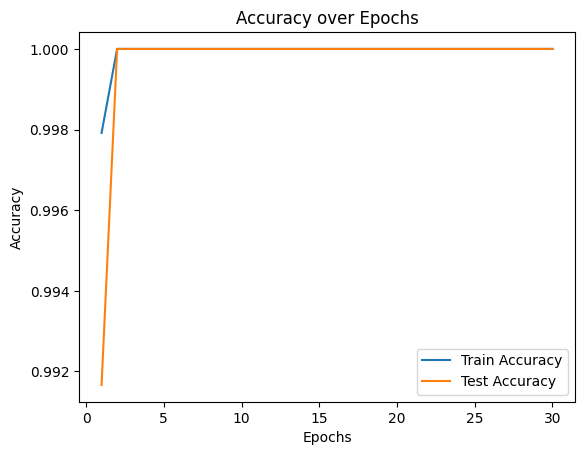

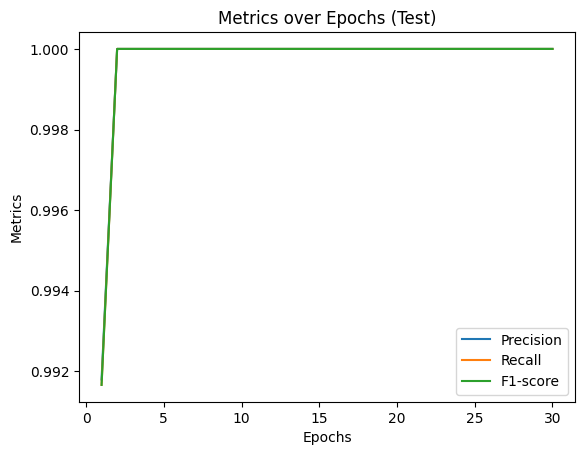

In [46]:
# Plot the accuracy over epochs for training and validation
print(len(val_accuracy_list))
plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_list, label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()


# Plot precision, recall, and F1-score over epochs for validation
plt.plot(range(1, num_epochs + 1), precision_list, label='Precision')
plt.plot(range(1, num_epochs + 1), recall_list, label='Recall')
plt.plot(range(1, num_epochs + 1), f1_list, label='F1-score')
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Metrics over Epochs (Test)")
plt.legend()
plt.show()